## Distance matrix based on the centroids

1. Firts we calculate the distance matriz between the people
2. We obtain the mean of the distance of each parcel of the producer (one producer could have more than one parcel)
3. To obtain only one value per producer we make a PCA

In [27]:
import geopandas as gpd
import folium

# Cargar el shapefile
shapefile_path = '../DataIn/Centroides/Centroides_Nome_atu.shp'  
gdf = gpd.read_file(shapefile_path)

In [29]:
# Crear un mapa con Folium
mapa = folium.Map(location=[gdf.geometry.y.mean(), gdf.geometry.x.mean()], zoom_start=13)

# Añadir las parcelas al mapa
for _, row in gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row['0_Nome_atu']
    ).add_to(mapa)

mapa

In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# Cargar el archivo Excel
file_path = '../DataIn/Centroides.xlsx'  
xls = pd.ExcelFile(file_path)

# Cargar la hoja `matriz_de_distancia` en un DataFrame
df = pd.read_excel(xls, sheet_name='centroides_nome_atu')

# Asumimos que el DataFrame contiene las columnas '0_Nome_atu', 'X', 'Y'
productores = df['0_Nome_atu'].unique()

# Crear una lista para almacenar las distancias promedio entre parcelas de cada productor
dist_avg_per_productor = []

# Calcular la distancia promedio entre parcelas de cada productor
for productor in productores:
    parcelas = df[df['0_Nome_atu'] == productor]
    coords = parcelas[['X', 'Y']].values
    dist_matrix = np.zeros((len(coords), len(coords)))
    
    for i in range(len(coords)):
        for j in range(len(coords)):
            if i != j:
                dist_matrix[i, j] = geodesic(coords[i], coords[j]).meters
                
    # Calcular la distancia promedio
    avg_distance = np.mean(dist_matrix[np.triu_indices(len(coords), k=1)])
    dist_avg_per_productor.append((productor, avg_distance))


In [17]:
# Convertir la lista en un DataFrame
dist_avg_df = pd.DataFrame(dist_avg_per_productor, columns=['productor', 'avg_dist_within'])

# Crear una matriz de distancias promedio entre productores
dist_matrix_between_productores = np.zeros((len(productores), len(productores)))

for i in range(len(productores)):
    for j in range(len(productores)):
        if i != j:
            coords_i = df[df['0_Nome_atu'] == productores[i]][['X', 'Y']].values
            coords_j = df[df['0_Nome_atu'] == productores[j]][['X', 'Y']].values
            dists = []
            for coord_i in coords_i:
                for coord_j in coords_j:
                    dists.append(geodesic(coord_i, coord_j).meters)
            dist_matrix_between_productores[i, j] = np.mean(dists)

# Crear un DataFrame con los nombres de los productores y la matriz de distancias entre productores
dist_matrix_between_productores_df = pd.DataFrame(dist_matrix_between_productores, index=productores, columns=productores)



c:\Users\jesus\anaconda3\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


La matriz de distancias y las distancias promedio se han guardado en 'Matriz_distancia_calculada.xlsx'


In [ ]:
# Guardar la matriz de distancias y las distancias promedio en un archivo Excel
output_path = '../DataIntermediate/Matriz_distancia_calculada.xlsx'
with pd.ExcelWriter(output_path) as writer:
    dist_matrix_between_productores_df.to_excel(writer, sheet_name='Matriz_de_Distancias_Entre_Productores')
    dist_avg_df.to_excel(writer, sheet_name='Distancias_Promedio_Dentro', index=False)

print("La matriz de distancias y las distancias promedio se han guardado en 'Matriz_distancia_calculada.xlsx'")

In [18]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [19]:
# Realizar PCA sobre la matriz de distancias
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dist_matrix_between_productores_df)

# Crear un DataFrame con los resultados del PCA
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=productores)

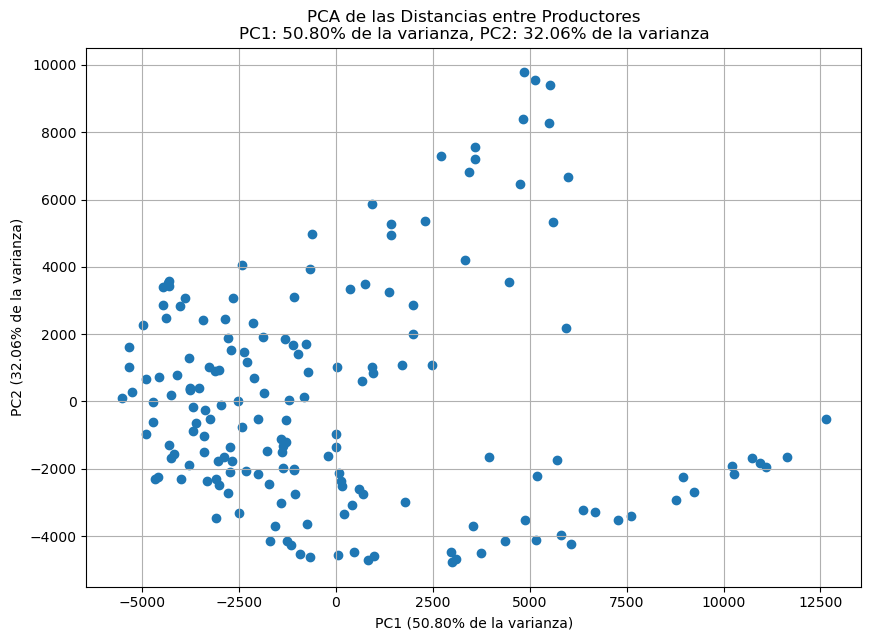

In [24]:
# Realizar PCA sobre la matriz de distancias
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dist_matrix_between_productores_df)

# Crear un DataFrame con los resultados del PCA
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=dist_matrix_between_productores_df.index)

# Calcular el porcentaje de varianza explicada por cada componente principal
explained_variance = pca.explained_variance_ratio_


# Guardar la matriz de distancias, las distancias promedio y los resultados del PCA en un archivo Excel
output_path = '../DataIntermediate/Matriz_distancia_calculada_con_PCA.xlsx'
with pd.ExcelWriter(output_path) as writer:
    pca_df.to_excel(writer, sheet_name='PCA_Result')

# Graficar los resultados del PCA sin etiquetas
plt.figure(figsize=(10, 7))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.title(f'PCA de las Distancias entre Productores\nPC1: {explained_variance[0]*100:.2f}% de la varianza, PC2: {explained_variance[1]*100:.2f}% de la varianza')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}% de la varianza)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}% de la varianza)')
plt.grid(True)
plt.show()
